## A tutorial for using Tools21cm to create mock 21-cm radio measurement

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tools21cm as t2c

In [2]:
from tqdm import tqdm
from glob import glob
from time import time

### Simulate cosmic reionization
We will use the interface to the [21cmfast](https://21cmfast.readthedocs.io/en/latest/) code to create simulations of the 21-cm signal during the peoch of reionization.

#### Initial conditions
To begin modelling of cosmic structure formation, we initialise a gaussian random field (GRF) for matte in comoving coordinates. This field is normalised to match the linear matter power spectrum, which can be modelled with fitting functions (e.g. [Eisenstein & Hu 1998](https://arxiv.org/abs/astro-ph/9709112)) or using a Boltzmann solver (e.g. [CLASS](https://github.com/lesgourg/class_public) and [CAMB](https://camb.readthedocs.io/en/latest/)). In 21cmfast, the Eisenstein & Hu (1998) fit is implemented for LCDM.

In [39]:
HII_DIM = 128
BOX_LEN = 256

ic = t2c.run_21cmfast_init(                    
    user_params={"HII_DIM":HII_DIM, "DIM":HII_DIM*3, "BOX_LEN":BOX_LEN, "USE_INTERPOLATION_TABLES": True},
    cosmo_params={"OMb":0.049, "OMm":0.31, "POWER_INDEX":0.96, "SIGMA_8":0.83, "hlittle":0.67},
    write=False,
    )

print(f'This object contains the following fields:\n {ic.fields}')

Creating initial conditions...
...done
This object contains the following fields:
 {'lowres_density': <_cffi_backend.CField object at 0x1451bc6f0>, 'lowres_vx': <_cffi_backend.CField object at 0x1451bf720>, 'lowres_vy': <_cffi_backend.CField object at 0x1451bf540>, 'lowres_vz': <_cffi_backend.CField object at 0x1451bf990>, 'lowres_vx_2LPT': <_cffi_backend.CField object at 0x1451bea90>, 'lowres_vy_2LPT': <_cffi_backend.CField object at 0x1451bfb70>, 'lowres_vz_2LPT': <_cffi_backend.CField object at 0x1451bfba0>, 'hires_density': <_cffi_backend.CField object at 0x1451bf630>, 'hires_vx': <_cffi_backend.CField object at 0x1451bf120>, 'hires_vy': <_cffi_backend.CField object at 0x1451bf3c0>, 'hires_vz': <_cffi_backend.CField object at 0x1451bf7e0>, 'hires_vx_2LPT': <_cffi_backend.CField object at 0x1451bf9f0>, 'hires_vy_2LPT': <_cffi_backend.CField object at 0x1451bd650>, 'hires_vz_2LPT': <_cffi_backend.CField object at 0x1451be550>, 'lowres_vcb': <_cffi_backend.CField object at 0x1451bfcf0

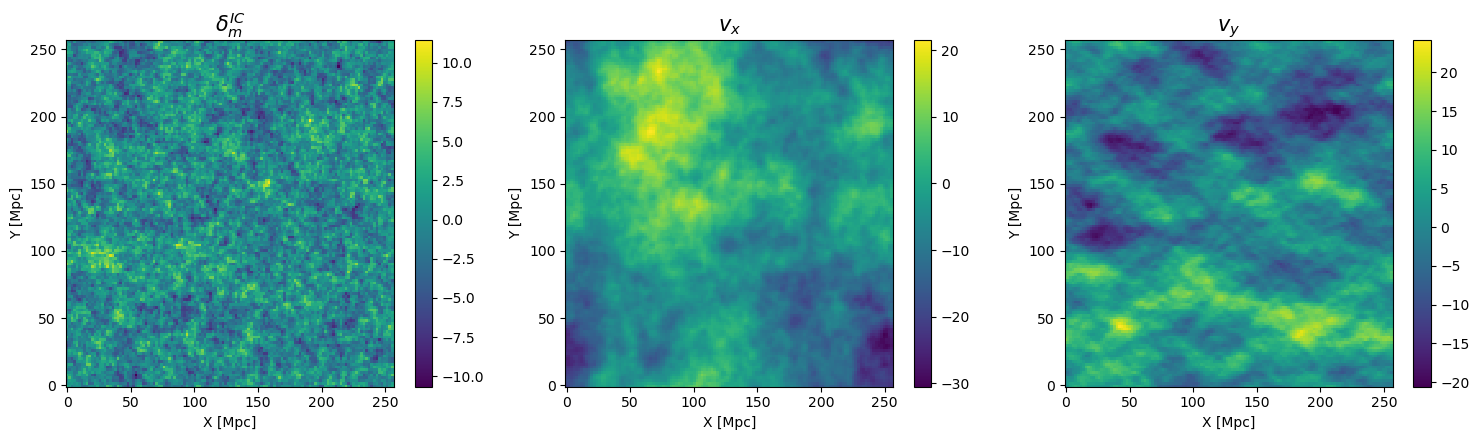

In [40]:
fig, axs = plt.subplots(1,3,figsize=(15,4.5))

axs[0].set_title('$\delta^{IC}_m$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_density.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_density.shape[2])
c0 = axs[0].pcolor(xx, yy, ic.lowres_density[10])
fig.colorbar(c0, ax=axs[0], orientation='vertical') 

axs[1].set_title('$v_x$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_vx.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_vx.shape[2])
c1 = axs[1].pcolor(xx, yy, ic.lowres_vx[10])
fig.colorbar(c1, ax=axs[1], orientation='vertical') 

axs[2].set_title('$v_y$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_vy.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_vy.shape[2])
c2 = axs[2].pcolor(xx, yy, ic.lowres_vy[10])
fig.colorbar(c2, ax=axs[2], orientation='vertical') 

for ax in axs:
    ax.set_xlabel('X [Mpc]')
    ax.set_ylabel('Y [Mpc]')

plt.tight_layout()
plt.show()

### Matter distribution

Note that, in case of more accurate frameworks (e.g. N-body simulation), this field is not called the initial conditions. For these frameworks, this GRF is perturbed using Lagrangian perturbation theory (LPT) at a very high redshift. 21cmfast is a semi-numerical code and, therefore, LPT corrected matter field used as the matter fields at different redshifts.

In [41]:
dens = t2c.run_21cmfast_matter(
        [9.0,7.0],
        init_box=ic,
        write=False,
        )

print(f'This output contains: \n {dens.keys()}')

Creating matter distribution...
...done
This output contains: 
 dict_keys([9.0, 7.0])


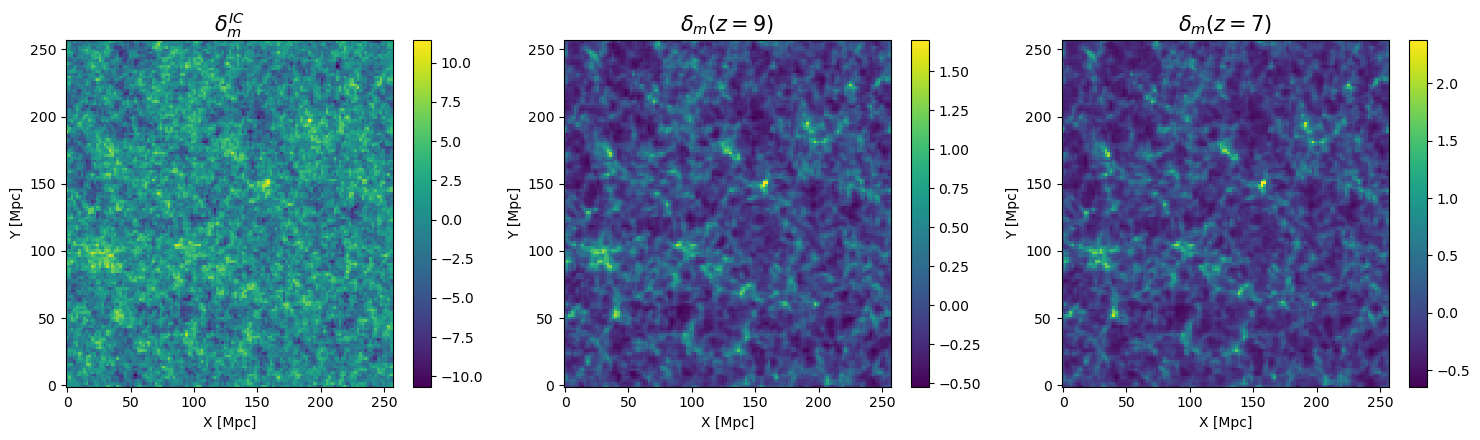

In [42]:
fig, axs = plt.subplots(1,3,figsize=(15,4.5))

axs[0].set_title('$\delta^{IC}_m$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_density.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, ic.lowres_density.shape[2])
c0 = axs[0].pcolor(xx, yy, ic.lowres_density[10])
fig.colorbar(c0, ax=axs[0], orientation='vertical')

axs[1].set_title('$\delta_m(z=9)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, dens[9.0].density.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, dens[9.0].density.shape[2])
c1 = axs[1].pcolor(xx, yy, dens[9.0].density[10])
fig.colorbar(c1, ax=axs[1], orientation='vertical')

axs[2].set_title('$\delta_m(z=7)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, dens[7.0].density.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, dens[7.0].density.shape[2])
c2 = axs[2].pcolor(xx, yy, dens[7.0].density[10])
fig.colorbar(c2, ax=axs[2], orientation='vertical')

for ax in axs:
    ax.set_xlabel('X [Mpc]')
    ax.set_ylabel('Y [Mpc]')

plt.tight_layout()
plt.show()


### Simulate reionization
21cmfast models the ionising sources to reside in the dark matter haloes that is simulated from the matter field using the extended Press-Schechter formalism. Reionization is modelled based on the semi-numerical formalism developed in [Furlanetto et al. (2004)](https://arxiv.org/abs/astro-ph/0403697). The properties of the light sources are defined with the `astro_params` parameter below.

In [43]:
coevals = t2c.run_21cmfast_coeval(
        [9.0,7.0],
        init_box=ic,
        astro_params={"F_STAR10":np.log10(0.05), "ALPHA_STAR":0.5, "F_ESC10":np.log10(0.1), "ALPHA_ESC":-0.5, "t_STAR":0.5, "M_TURN":8.7, "R_BUBBLE_MAX":15, "L_X":40},
        flag_options={"USE_HALO_FIELD":False, "USE_MASS_DEPENDENT_ZETA":True, "INHOMO_RECO":False, "PHOTON_CONS":False},
        write=False,
        )

print(f'This output contains: \n {coevals.keys()}')

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Modelling reionization...


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


...done
This output contains: 
 dict_keys([9.0, 7.0])


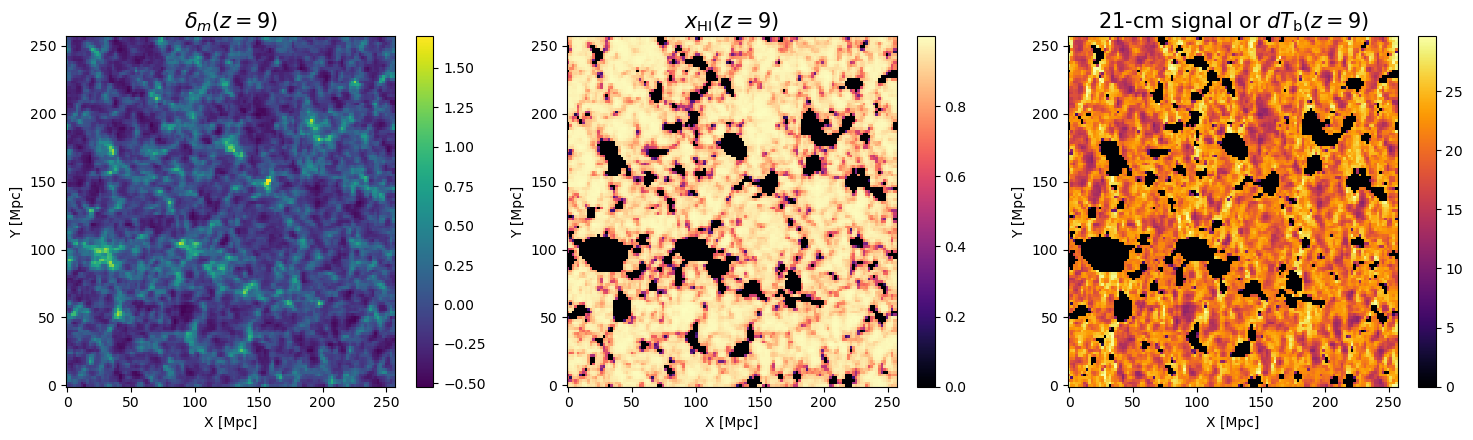

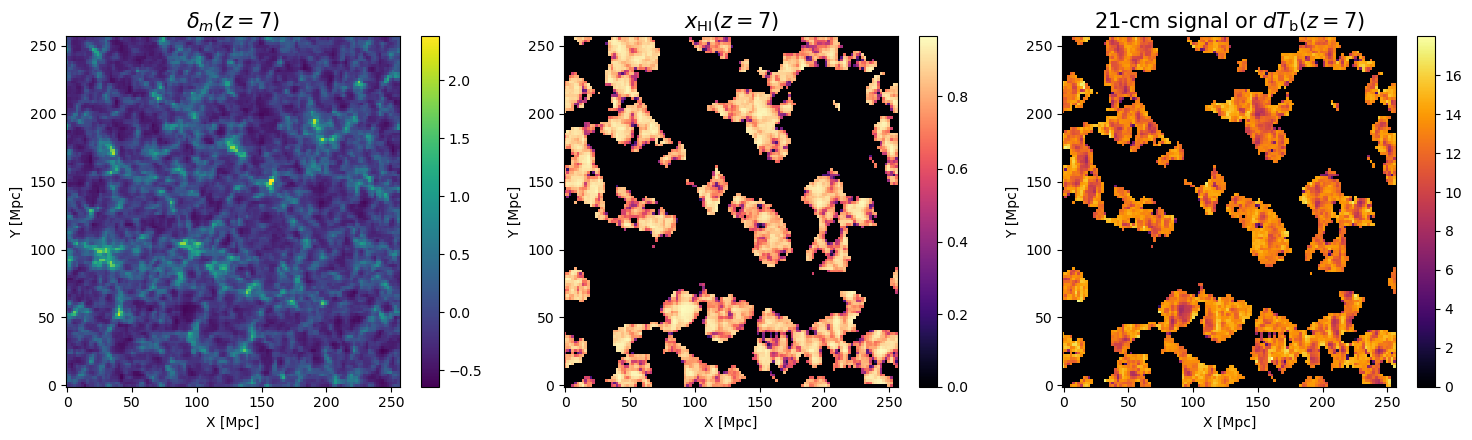

In [44]:
fig, axs = plt.subplots(1,3,figsize=(15,4.5))

axs[0].set_title('$\delta_m(z=9)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, dens[9.0].density.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, dens[9.0].density.shape[2])
c0 = axs[0].pcolor(xx, yy, dens[9.0].density[10])
fig.colorbar(c0, ax=axs[0], orientation='vertical')

axs[1].set_title(r'$x_\mathrm{HI}(z=9)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, coevals[9.0].xH_box.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, coevals[9.0].xH_box.shape[2])
c1 = axs[1].pcolor(xx, yy, coevals[9.0].xH_box[10], cmap='magma')
fig.colorbar(c1, ax=axs[1], orientation='vertical')

axs[2].set_title(r'21-cm signal or $dT_\mathrm{b}(z=9)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, coevals[9.0].brightness_temp.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, coevals[9.0].brightness_temp.shape[2])
c2 = axs[2].pcolor(xx, yy, coevals[9.0].brightness_temp[10], cmap='inferno')
fig.colorbar(c2, ax=axs[2], orientation='vertical')

for ax in axs:
    ax.set_xlabel('X [Mpc]')
    ax.set_ylabel('Y [Mpc]')

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1,3,figsize=(15,4.5))

axs[0].set_title('$\delta_m(z=7)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, dens[7.0].density.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, dens[7.0].density.shape[2])
c0 = axs[0].pcolor(xx, yy, dens[7.0].density[10])
fig.colorbar(c0, ax=axs[0], orientation='vertical')

axs[1].set_title(r'$x_\mathrm{HI}(z=7)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, coevals[7.0].xH_box.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, coevals[7.0].xH_box.shape[2])
c1 = axs[1].pcolor(xx, yy, coevals[7.0].xH_box[10], cmap='magma')
fig.colorbar(c1, ax=axs[1], orientation='vertical')

axs[2].set_title(r'21-cm signal or $dT_\mathrm{b}(z=7)$', fontsize=15)
xx = np.linspace(0, ic.user_params.BOX_LEN, coevals[7.0].brightness_temp.shape[1])
yy = np.linspace(0, ic.user_params.BOX_LEN, coevals[7.0].brightness_temp.shape[2])
c2 = axs[2].pcolor(xx, yy, coevals[7.0].brightness_temp[10], cmap='inferno')
fig.colorbar(c2, ax=axs[2], orientation='vertical')

for ax in axs:
    ax.set_xlabel('X [Mpc]')
    ax.set_ylabel('Y [Mpc]')

plt.tight_layout()
plt.show()


### Light-cones

The 21-cm signal will be observed as a function of field of view and frequency, which is known as a 21-cm light-cone. Therefore, we will not get cubes at every redshift as the simulations provide us. We can construct such light-cone with Tools21cm.

We first simulate the 21-cm signal at different redshifts.

In [45]:
file_redshifts = np.arange(5.4,12,0.10)
coevals_full   =  t2c.run_21cmfast_coeval(
        file_redshifts,
        init_box=ic,
        astro_params={"F_STAR10":np.log10(0.05), "ALPHA_STAR":0.5, "F_ESC10":np.log10(0.1), "ALPHA_ESC":-0.5, "t_STAR":0.5, "M_TURN":8.7, "R_BUBBLE_MAX":15, "L_X":40},
        flag_options={"USE_HALO_FIELD":False, "USE_MASS_DEPENDENT_ZETA":True, "INHOMO_RECO":False, "PHOTON_CONS":False},
        write=False,
        )

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Modelling reionization...


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The followin

...done


In [46]:
lc_dens_phy, lc_dens_zs = t2c.make_lightcone(
               {zi: coevals_full[zi].density for zi in file_redshifts}, 
               z_low=None, 
               z_high=None, 
               depth_mhz=None, 
               file_redshifts=file_redshifts, 
               cbin_bits=32, 
               cbin_order='c', 
               los_axis=0, 
               raw_density=False, 
               interpolation='linear', 
               reading_function=None, 
               box_length_mpc=ic.user_params.BOX_LEN,
              )

Making lightcone between 5.400000 < z < 11.894424


100%|███████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 10239.38it/s]

...done


In [47]:
lc_xHI_phy, lc_xHI_zs = t2c.make_lightcone(
               {zi: coevals_full[zi].xH_box for zi in file_redshifts}, 
               z_low=None, 
               z_high=None, 
               depth_mhz=None, 
               file_redshifts=file_redshifts, 
               cbin_bits=32, 
               cbin_order='c', 
               los_axis=0, 
               raw_density=False, 
               interpolation='linear', 
               reading_function=None, 
               box_length_mpc=ic.user_params.BOX_LEN,
              )

Making lightcone between 5.400000 < z < 11.894424


100%|███████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 10336.86it/s]

...done


In [48]:
lc_21cm_phy, lc_21cm_zs = t2c.make_lightcone(
               {zi: coevals_full[zi].brightness_temp for zi in file_redshifts}, 
               z_low=None, 
               z_high=None, 
               depth_mhz=None, 
               file_redshifts=file_redshifts, 
               cbin_bits=32, 
               cbin_order='c', 
               los_axis=0, 
               raw_density=False, 
               interpolation='linear', 
               reading_function=None, 
               box_length_mpc=ic.user_params.BOX_LEN,
              )

Making lightcone between 5.400000 < z < 11.894424


100%|████████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 8239.83it/s]

...done


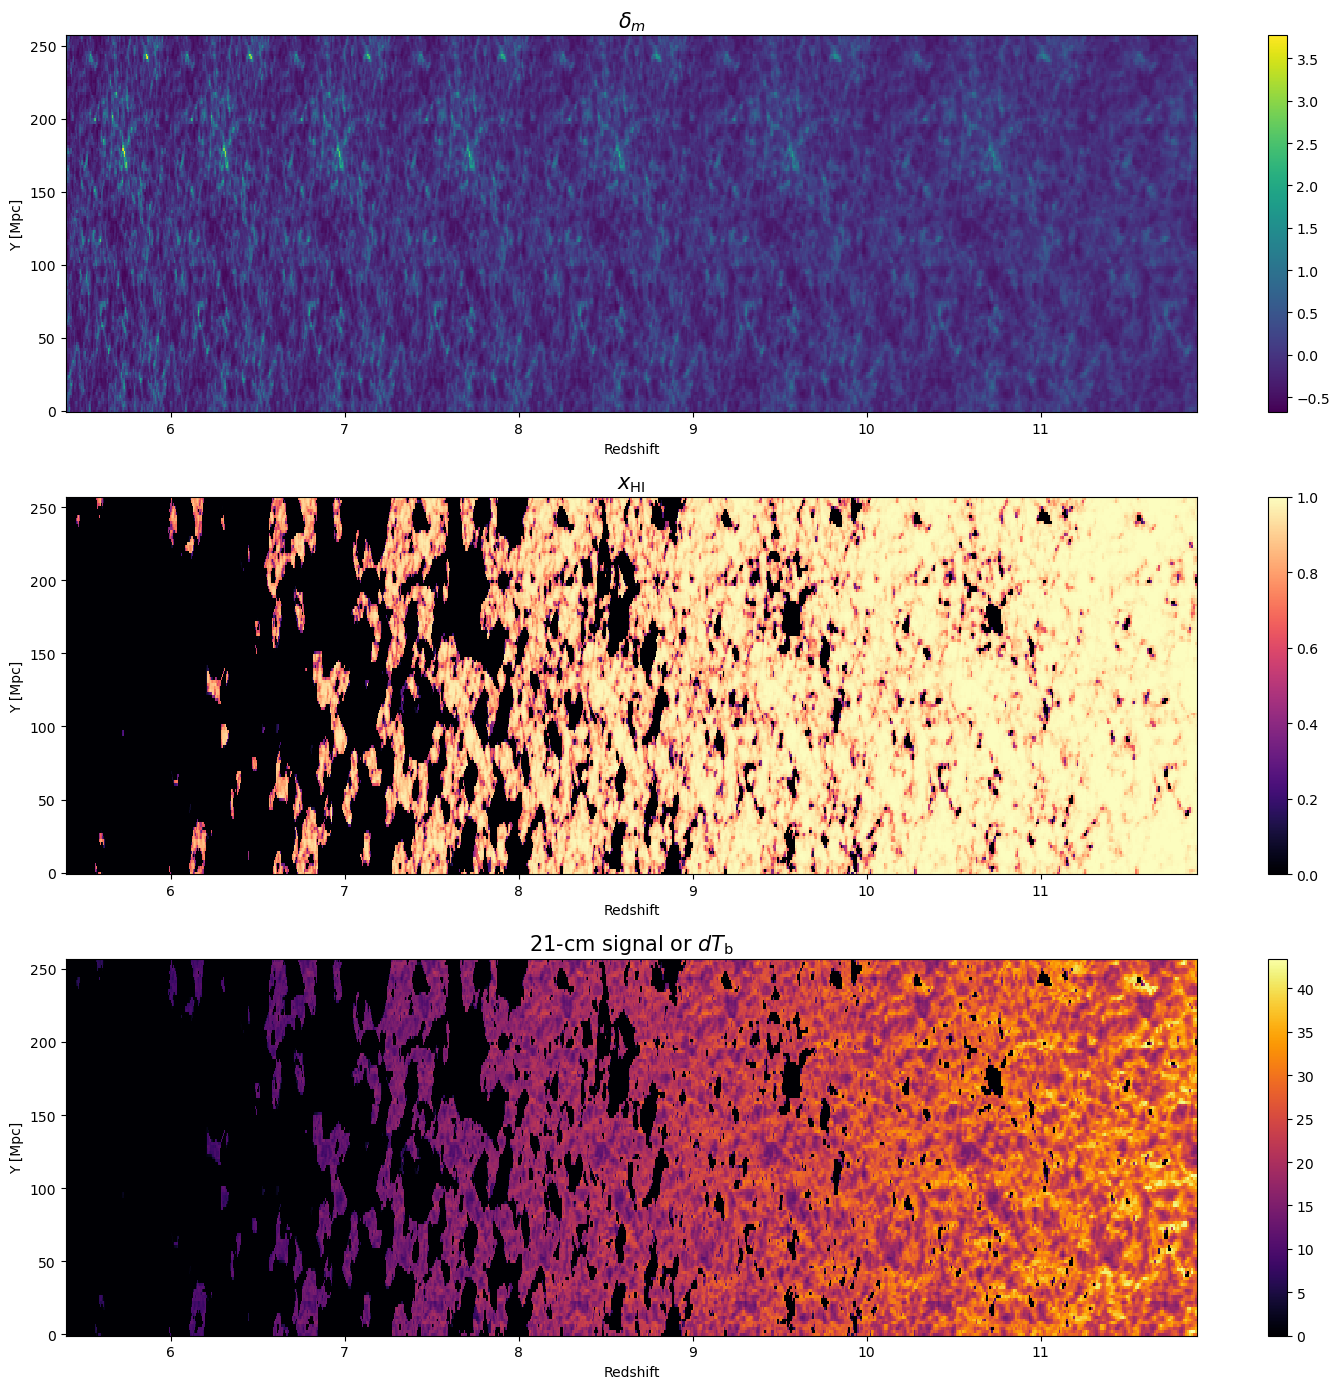

In [56]:
fig, axs = plt.subplots(3,1,figsize=(15,14))

axs[0].set_title('$\delta_m$', fontsize=15)
xx = lc_dens_zs.copy()
yy = np.linspace(0, ic.user_params.BOX_LEN, lc_dens_phy.shape[1])
c0 = axs[0].pcolor(xx, yy, lc_dens_phy[10])
fig.colorbar(c0, ax=axs[0], orientation='vertical')

axs[1].set_title(r'$x_\mathrm{HI}$', fontsize=15)
xx = lc_xHI_zs.copy()
yy = np.linspace(0, ic.user_params.BOX_LEN, lc_xHI_phy.shape[1])
c1 = axs[1].pcolor(xx, yy, lc_xHI_phy[10], cmap='magma')
fig.colorbar(c1, ax=axs[1], orientation='vertical')

axs[2].set_title(r'21-cm signal or $dT_\mathrm{b}$', fontsize=15)
xx = lc_21cm_zs.copy()
yy = np.linspace(0, ic.user_params.BOX_LEN, lc_21cm_phy.shape[1])
c2 = axs[2].pcolor(xx, yy, lc_21cm_phy[10], cmap='inferno')
fig.colorbar(c2, ax=axs[2], orientation='vertical')

for ax in axs:
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Y [Mpc]')

plt.tight_layout()
plt.show()

### Light-cones in observational units

The simulations are performed in comoving units (Mpc) at different redshifts, which is the units for the simulated light-cones above. But observations will record degrees or arcminutes for field of view and frequency or wavelength for redshifts. The simulation and observational units are not linear conversions. Therefore the simulated light-cone has to be re-gridded in the observational units.

In [52]:
output_dnu = 0.1 #MHz
output_dtheta = 1 #arcmin

lc_21cm_obs, lc_21cm_nu = t2c.physical_lightcone_to_observational(
                    lc_21cm_phy, 
                    lc_21cm_zs.min(), 
                    output_dnu, 
                    output_dtheta, 
                    input_box_size_mpc=ic.user_params.BOX_LEN, 
                    verbose=True, 
                    order=2
                    )

100%|███████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:01<00:00, 639.43it/s]


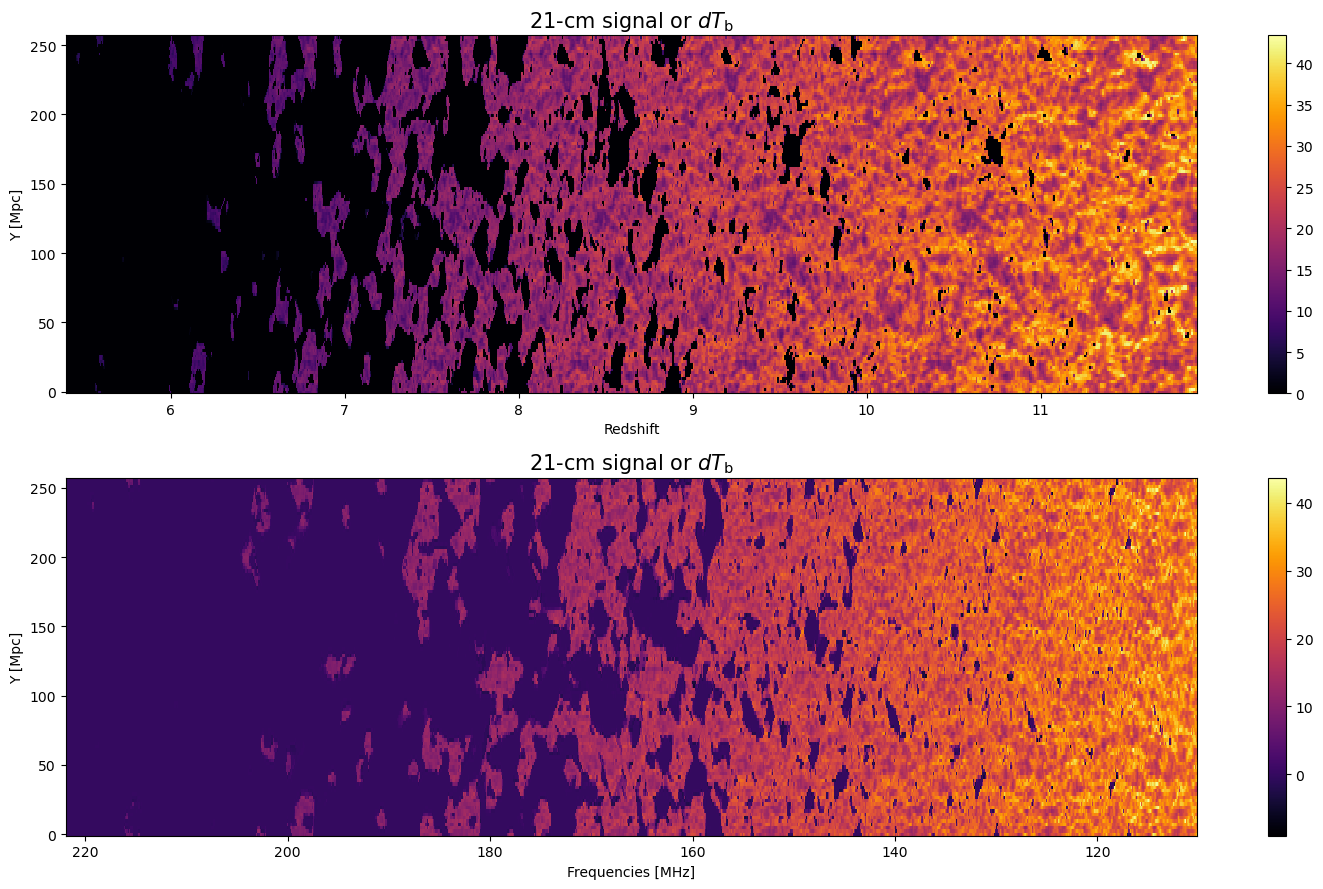

In [58]:
fig, axs = plt.subplots(2,1,figsize=(15,9))

axs[0].set_title(r'21-cm signal or $dT_\mathrm{b}$', fontsize=15)
xx = lc_21cm_zs.copy()
yy = np.linspace(0, ic.user_params.BOX_LEN, lc_21cm_phy.shape[1])
c0 = axs[0].pcolor(xx, yy, lc_21cm_phy[10], cmap='inferno')
fig.colorbar(c0, ax=axs[0], orientation='vertical')
axs[0].set_xlabel('Redshift')

axs[1].set_title(r'21-cm signal or $dT_\mathrm{b}$', fontsize=15)
xx = lc_21cm_nu.copy()
yy = np.linspace(0, ic.user_params.BOX_LEN, lc_21cm_obs.shape[1])
c1 = axs[1].pcolor(xx, yy, lc_21cm_obs[10], cmap='inferno')
fig.colorbar(c1, ax=axs[1], orientation='vertical')
axs[1].invert_xaxis()
axs[1].set_xlabel('Frequencies [MHz]')

for ax in axs:
    ax.set_ylabel('Y [Mpc]')

plt.tight_layout()
plt.show()